<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/Parimala_Kettymuthu_HW7_task_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [431]:
#Defined the autoreload functionality
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [432]:
#Imported/installed required packages and defined the google drive access, basepath & added system path to custom-functions
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext --upgrade --q
  !pip install torchmetrics --q
  !pip install --quiet torch-lr-finder --q
  !pip install --upgrade wandb --q
  !pip install --gensim --q

  basepath = '/content/drive/My Drive/NLP'
  sys.path.append('/content/drive/My Drive/NLP/custom-functions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --gensim


In [433]:
#Importing the required packages
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
from torchmetrics.classification import MultilabelF1Score, MultilabelHammingDistance
from torchmetrics.functional.classification import multilabel_f1_score,multilabel_hamming_distance

import joblib
import ast
import wandb

from types import SimpleNamespace
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer as mlb

In [434]:
#Defined the google drive folders for accessing/saving model progress
embeddings_folder = Path(basepath)/ 'assignment7/WordEmbeddings'
data_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'
model_saving_folder = Path(basepath)/ 'assignment7/NN_MultiLabel_Classification_task3b'


In [435]:
#Access the joblib file and load the dataset
data_cleaned = data_folder/ "df_multilabel_hw_cleaned.joblib"
stackExchange_dataset = joblib.load(data_cleaned)

In [436]:
#Defined the X & y variables from the dataset
X = stackExchange_dataset['cleaned_text'].values
y = stackExchange_dataset['Tag_Number'].values

In [437]:
#Installed swifter packages
!pip install swifter -qq  

In [438]:
#Installed required packages, and converted Tag_Number using ast module
import swifter
import ast
stackExchange_dataset['Tag_number_list'] = stackExchange_dataset['Tag_Number'].swifter.apply(lambda x: ast.literal_eval(x))

Pandas Apply:   0%|          | 0/47427 [00:00<?, ?it/s]

In [439]:
y_final = stackExchange_dataset['Tag_number_list'].values

In [440]:
#from sklearn.preprocessing import MultiLabelBinarizer as mlb
y_stackExchange_encoding = mlb().fit_transform(y_final)

In [441]:
#Splitted the dataset into train, test & valid proportionally
from sklearn.model_selection import train_test_split
X_sExchange_train, X_valid_test, y_sExchange_train, y_valid_test = train_test_split(X, y_stackExchange_encoding, test_size=0.4, random_state=42)
X_sExchange_valid, X_sExchange_test, y_sExchange_valid, y_sExchange_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

In [442]:
#Accessiing binary file from the given folder and loaded the vectors using KeyedVectors
from gensim.models import KeyedVectors
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [443]:
#Installed learning rate finder package
!pip install torch_lr_finder -qq

In [444]:
#Importing the Learing Rate finder & other custom packages
from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import *

In [445]:
#Importing the custom packages
from ff_sequential_model_v1 import MLPCustom

#Creating Dataset & Vocab

In [446]:
#Created the respective custom Dataset 
import random
se_trainset_org = CustomDataset(X_sExchange_train, y_sExchange_train)
se_validset = CustomDataset(X_sExchange_valid, y_sExchange_valid)
se_testset = CustomDataset(X_sExchange_test, y_sExchange_test)
max_len = int(len(se_trainset_org)*0.25)
se_train_subset_indices = random.sample(range(0, len(se_trainset_org)), max_len)
se_trainset = torch.utils.data.Subset(se_trainset_org, se_train_subset_indices)
#Creating stackexchange vocab
stackExchange_vocab = get_vocab(se_trainset, min_freq=2)

In [447]:
#Getting pretrained weights from the generated vocabulary & vectors and the given embedding dimension
pretrained_weights, words_found, words_not_found = get_pretrained_weights(
    vocab=stackExchange_vocab,
    pretrained_vectors=sExchange_vectors,
    embedding_dim = 300,
    )

In [448]:
pretrained_weights.shape

torch.Size([25477, 300])

In [449]:
type(pretrained_weights), words_found, words_not_found

(torch.Tensor, 7894, 17583)

In [450]:
#Defined the hyperparameters needed for the model 
hyperparameters = SimpleNamespace(
    # for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(stackExchange_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[200],
    DPROB_LIST=[0.0],
    NON_LINEARITY=nn.ReLU(),
    BATCH_NORM=False,

    # for training
    INITIALIZATION ='kaiming',
    EPOCHS=20,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    DATASET='IMDB',
    ARCHITECTURE='embed_layer-ffn',

    # for optimizer
    OPTIMIZER='AdamW',
    MOMENTUM = 0,
    NESTEROV = False,
    WEIGHT_DECAY = 0.000,

    # gradient clipping
    CLIP_TYPE='norm',
    CLIP_VALUE=2,

    # early stopping
    EARLY_STOP_PATIENCE=5,

    #scheduler
    SCHEDULER = 'None'
    )

Specify the run name and folder

In [451]:
#Defined the path for saving the project & subsequent model run results
project_name = 'Regularization_stackExchange_v4'
run_name = 'exp8'
run_folder = model_saving_folder/project_name/run_name
run_folder.mkdir(exist_ok=True, parents=True)
log_frequency = 5

In [452]:
run_folder

PosixPath('/content/drive/My Drive/NLP/assignment7/NN_MultiLabel_Classification_task3b/Regularization_stackExchange_v4/exp8')

In [453]:
###   Given the parameters and its subsequent runs   

# run 1 - based on default initialization
# Notes: Final Learning rate was set to 0.01

# run 2 - add dropout
hyperparameters.LEARNING_RATE = 0.01   
hyperparameters.DPROB_LIST=[0.5] 

# run 3 - remove dropout, add weight decay
hyperparameters.WEIGHT_DECAY = 1
hyperparameters.DPROB_LIST=[0] 

# run 4 - remove dropout, add weight decay
hyperparameters.WEIGHT_DECAY = 0.1

# run 5 - increase batch size to 256
hyperparameters.BATCH_SIZE = 256

# run 6 - One cyucle scheduler
hyperparameters.LEARNING_RATE = 0.001   
hyperparameters.WEIGHT_DECAY = 10
hyperparameters.SCHEDULER='OneCyclicLR'
hyperparameters.SCHEDULER_MAX_LR=0.01
hyperparameters.SCHEDULER_DIV_FACTOR=25
hyperparameters.SCHEDULER_FINAL_DIV_FACTOR=1e3
hyperparameters.EPOCHS = 10

#  run 7 - use pre-trained weights but freeze teh weights - model will 
hyperparameters.USE_PRE_TRAINED_WEIGHTS = True
hyperparameters.FREEZE_PRETRAINED = True

# # run 8 - Unfreeze the weights
hyperparameters.FREEZE_PRETRAINED = False

Trainer Configuration

In [454]:
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=stackExchange_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset=se_trainset, validset=se_validset, 
                                         batch_size_=hyperparameters.BATCH_SIZE,
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss()

# model
model_stackExchange = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_SIZES_LIST,
                       hyperparameters.DPROB_LIST,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY,
                       hyperparameters.BATCH_NORM,                       
                       use_pre_trained_weights =hyperparameters.USE_PRE_TRAINED_WEIGHTS,
                       pretrained_weights=pretrained_weights, 
                       freeze_pretrained = hyperparameters.FREEZE_PRETRAINED)

def init_weights(m):
  if type(m) == nn.Linear:
      torch.nn.init.kaiming_normal_(m.weight)
      torch.nn.init.zeros_(m.bias)

# apply initialization recursively  to all modules
if hyperparameters.INITIALIZATION =='kaiming':
    model_stackExchange.apply(init_weights)

# OPTIMIZERS
def get_optimizer():
    if hyperparameters.OPTIMIZER == "SGD":
        optimizer = torch.optim.SGD(
            model_stackExchange.parameters(),
            lr=hyperparameters.LEARNING_RATE,
            momentum=hyperparameters.MOMENTUM,
            nesterov=hyperparameters.NESTEROV,
            weight_decay = hyperparameters.WEIGHT_DECAY
        )
    else:
        optimizer = torch.optim.AdamW(
            model_stackExchange.parameters(), 
            lr=hyperparameters.LEARNING_RATE,
            weight_decay = hyperparameters.WEIGHT_DECAY

        )
    return optimizer

optimizer = get_optimizer()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [455]:
model_stackExchange  #Displaying the model parameters

MLPCustom(
  (non_linearity): ReLU()
  (embedding): EmbeddingBag(25477, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [456]:
optimizer  #Displaying the optimizer parameters

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 10
)

Specify Trainer

In [457]:
#Created the trainer instance
trainer = Trainer(model=model_stackExchange, optimizer=optimizer,
                  criterion=loss_function, device=device)
# set loaders
trainer.set_loaders(train_loader, valid_loader)

Set Trainer based on Hyperparameters

In [458]:
# Reset Optimizer
trainer.set_optimizer(get_optimizer())

# set metric -- optional
train_metric = MultilabelHammingDistance(num_labels=10)
valid_metric = MultilabelHammingDistance(num_labels=10)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=True)

# set early stopping
trainer.set_early_stopping(patience = hyperparameters.EARLY_STOP_PATIENCE)

# set gradient clipping
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

steps_per_epoch = len(trainer.train_loader)
#Defined the scheduler with parameters
scheduler = torch.optim.lr_scheduler.OneCycleLR(trainer.optimizer, 
                                                hyperparameters.SCHEDULER_MAX_LR, 
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=hyperparameters.EPOCHS,
                                                div_factor=hyperparameters.SCHEDULER_DIV_FACTOR,
                                                final_div_factor=hyperparameters.SCHEDULER_FINAL_DIV_FACTOR)

trainer.set_lr_scheduler(scheduler=scheduler)

In [459]:
# set wandb -- OPTIONAL
trainer.set_wandb(project_name=project_name,
                  run_name=run_name, config=hyperparameters, log_batch=True, log_frequency=log_frequency)

train_epoch_loss,█▅▃▂▂▁▁▁▁▁
train_epoch_metric,█▆▄▄▃▁▁▁▁▁
val_epoch_loss,█▄▃▃▂▁▁▁▁▁
val_epoch_metric,█▅▄▃▂▁▁▁▁▁
train_epoch_loss,0.17798
train_epoch_metric,0.05554
val_epoch_loss,0.20802
val_epoch_metric,0.0742


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Sanity Check

In [460]:
#Performing the sanity check
trainer.sanity_check(num_classes=2)

Actual loss: 0.6925369623813822
Expected Theoretical loss: 0.6931471805599453


Trainer Model

In [461]:
#Training the model
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/10 - Train Loss: 0.5733, Train Metric: 0.2319, Train Time: 0:00:01.691163
Epoch 1/10 - Val Loss: 0.4497, Val Metric: 0.1851, Val Time: 0:00:01.509047
Current Learning rate is [0.0028526368380648003]

Epoch 2/10 - Train Loss: 0.3826, Train Metric: 0.1700, Train Time: 0:00:01.320572
Epoch 2/10 - Val Loss: 0.3258, Val Metric: 0.1352, Val Time: 0:00:01.556013
Current Learning rate is [0.0077041192441623255]

Epoch 3/10 - Train Loss: 0.2796, Train Metric: 0.1218, Train Time: 0:00:01.566071
Epoch 3/10 - Val Loss: 0.2758, Val Metric: 0.1271, Val Time: 0:00:01.330471
Current Learning rate is [0.009999357754690496]

Epoch 4/10 - Train Loss: 0.2601, Train Metric: 0.1207, Train Time: 0:00:01.771918
Epoch 4/10 - Val Loss: 0.2598, Val Metric: 0.1067, Val Time: 0:00:02.039968
Current Learning rate is [0.009469515781254656]

Epoch 5/10 - Train Loss: 0.2385, Train Metric: 0.0963, Train Time: 0:00:01.984463
Epoch 5/10 - Val Loss: 0.2247, Val Metric: 0.0892, Val Time: 0:00:01.475511
Current Lear

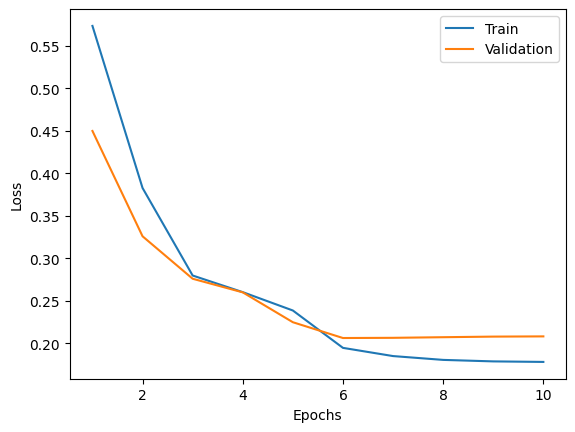

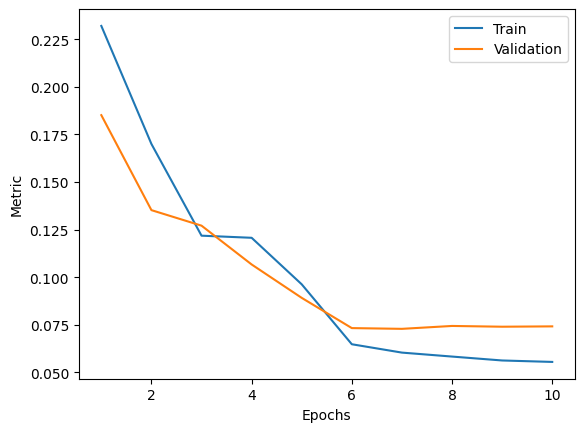

In [462]:
#Plotting the results
trainer.plot_history()

Get Accuracy & Predictions

In [463]:
#Defining the test loaders
test_loader = get_test_loaders(se_testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [464]:
trainer.timestamp

'2023-04-27_02-32-02'

In [465]:
#sacing the checking point
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/My Drive/NLP/assignment7/NN_MultiLabel_Classification_task3b/Regularization_stackExchange_v4/exp8/checkpoint_2023-04-27_02-32-02_best.pt'.


In [466]:
# Get the prediction and accuracy for the test dataset
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True, multilabel=True)
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True, multilabel=True)

In [467]:
metric = multilabel_hamming_distance
hd_train = metric(predictions_train, target_train, num_labels=10)
hd_valid = metric(predictions_valid, target_valid, num_labels=10)
hd_test = metric(predictions_test, target_test, num_labels=10)


In [468]:
# Print Hammo=imng Distance
print('Test hamming distance', hd_test )
print('Train hamming distance', hd_train )
print('Valid hamming distance', hd_valid )

Test hamming distance tensor(0.0760)
Train hamming distance tensor(0.0552)
Valid hamming distance tensor(0.0733)


In [469]:
from torchmetrics.functional.classification import multilabel_accuracy

In [470]:
#Setting the metric and passing the required data with label count
metric = multilabel_accuracy
acc_train = metric(predictions_train, target_train, num_labels=10)
acc_valid = metric(predictions_valid, target_valid, num_labels=10)
acc_test = metric(predictions_test, target_test, num_labels=10)


In [471]:
# Print Hamming Distance
print('Test accuracy', (acc_test)*100)
print('Train accuracy', (acc_train)*100)
print('Valid accuracy', (acc_valid)*100)

Test accuracy tensor(92.3983)
Train accuracy tensor(94.4799)
Valid accuracy tensor(92.6705)


In [472]:
#Calculating accuracy 
print('Test hamming distance', 1- acc_test)
print('Train hamming distance', 1- acc_train)
print('Valid hamming distance', 1- acc_valid)

Test hamming distance tensor(0.0760)
Train hamming distance tensor(0.0552)
Valid hamming distance tensor(0.0733)
